# Notebook examples for Chapter 5 Part 1

In [ ]:
import warnings
# these are innocuous but irritating
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
%matplotlib inline

## High-pass filtering and feature extraction
### Sobel filter

In [2]:
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
from matplotlib import cm
import auxil.auxil1 as auxil

# create filter
g = np.zeros((512,512),dtype=float)
g[:3,:3] = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])

#  shift Fourier transform to center    
a = np.reshape(range(512**2),(512,512))
i = a % 512
j = a / 512
g = (-1)**(i+j)*g

#  compute power spectrum and display    
p = np.abs(fft.fft2(g))**2
plt.imshow(auxil.linstr(p), cmap=cm.jet)

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_1.eps',bbox_inches='tight')

/home/mort/python/EESARDocker/venv3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/home/mort/python/EESARDocker/src/auxil/auxil1.py:523: RuntimeWarning: invalid value encountered in less
  tmp = np.where(tmp<0,0,tmp)
/home/mort/python/EESARDocker/src/auxil/auxil1.py:524: RuntimeWarning: invalid value encountered in greater
  tmp = np.where(tmp>255,255,tmp)


In [ ]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
from scipy import ndimage

gdal.AllRegister()
infile = 'imagery/AST_20070501'
inDataset = gdal.Open(infile,GA_ReadOnly)     
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    

band = inDataset.GetRasterBand(3)  
image = band.ReadAsArray(0,0,cols,rows).astype(float)
edges0 = ndimage.sobel(image,axis=0)
edges1 = ndimage.sobel(image,axis=1)

# comine and perform 2% saturated linear stretch
edges = auxil.lin2pcstr(np.abs(edges0+edges1))
plt.imshow(edges[200:400,200:400], cmap=cm.gray)   

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_2.eps',bbox_inches='tight')

### Laplacian of Gaussian filter

In [ ]:
# Laplacian filter
g = np.zeros((512,512),dtype=float)
g[:3,:3] = np.array([[0,1,0],[1,-4,1],[0,1,0]])

#  shift Fourier transform to center    
a = np.reshape(range(512**2),(512,512))
i = a % 512
j = a / 512
g = (-1)**(i+j)*g

#  compute power spectrum and display    
p = np.abs(fft.fft2(g))**2
plt.imshow(auxil.linstr(p), cmap=cm.jet)

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_3.eps',bbox_inches='tight')

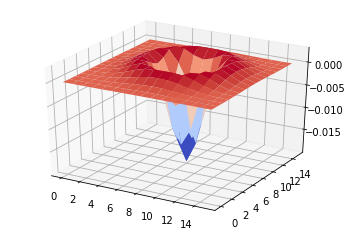

In [3]:
from mpl_toolkits.mplot3d import Axes3D

# Laplacian of Gaussian filter
sigma = 2.0
filt = np.zeros((16,16))
for i in range(16):
    for j in range(16):
        filt[i,j] = (1/(2*np.pi*sigma**6)) \
         *((i-8)**2+(j-8)**2-2*sigma**2) \
         *np.exp(-((i-8)**2+(j-8)**2)/(2*sigma**2))
fig = plt.figure()
ax = fig.gca(projection='3d') 
x, y = np.meshgrid(range(16),range(16))
ax.plot_surface(x, y, filt, cmap=cm.coolwarm)    

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_4.eps',bbox_inches='tight')

In [ ]:
# pad the ASTER image
impad = np.zeros((rows+16,cols+16))
impad[:rows,:cols] = image

# pad the filter as well
filtpad = impad*0.0
filtpad[:16,:16] = filt

# flilter in frequency domain
im = np.real(fft.ifft2(fft.fft2(impad)*fft.fft2(filtpad)))

In [ ]:
# get zero-crossings
idx = np.where( (im*np.roll(im,1,axis=0)<0) | \
                (im*np.roll(im,1,axis=1)<0) )

# get edge strengths
edges0 = ndimage.sobel(im,axis=0)
edges1 = ndimage.sobel(im,axis=1)
edges = auxil.lin2pcstr(np.abs(edges0+edges1))

# assign edge strengths at zero-crossings
im1 = 0.0*im
im1[idx] = edges[idx]
im1 = auxil.lin2pcstr(im1[200:400,200:400])
plt.imshow(im1,cmap=cm.gray) 

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_5.eps',bbox_inches='tight')

### Corner and edge detection

In [ ]:
%run scripts/ex5_1 -b 4 -a 1 imagery/LE7_20010626
%run scripts/ex5_1 -b 4 -a 2 imagery/LE7_20010626

In [ ]:
run scripts/dispms -f imagery/LE7_20010626_corner -e 3 -d [400,400,200,200] \
-F imagery/LE7_20010626_canny -E 2 -D [400,400,200,200] \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_6.eps'

In [ ]:
import ee
ee.Initialize()

im = ee.Image(
  'LANDSAT/LE07/C01/T1_RT_TOA/LE07_197025_20010626') \
       .select('B4')
edges = ee.Algorithms.CannyEdgeDetector(im,0.2)

gdexporttask = ee.batch.Export.image.toAsset(edges,
                      description='assetExportTask', 
                      assetId='users/mortcanty/edges',
                      scale=30,
                      maxPixels=1e9) 
gdexporttask.start()   

### Invariant moments

In [ ]:
import scipy.ndimage.interpolation as interp
# Airplanes
A = np.array([[0,0,0,0,0,1,0,0,0,0,0], 
             [0,0,0,0,1,1,1,0,0,0,0], 
             [0,0,0,0,1,1,1,0,0,0,0], 
             [0,0,0,1,1,1,1,1,0,0,0], 
             [0,0,1,1,0,1,0,1,1,0,0], 
             [0,1,1,0,0,1,0,0,1,1,0], 
             [1,0,0,0,0,1,0,0,0,0,1], 
             [0,0,0,0,0,1,0,0,0,0,0], 
             [0,0,0,0,1,1,1,0,0,0,0], 
             [0,0,0,0,0,1,0,0,0,0,0]])
im = np.zeros((200,200))
im[50:60,30:41] = A
im1 = im*0
im1[75:125,50:105] = auxil.rebin(A,(50,55))
im2 = interp.rotate(im1,45)
plt.imshow(im + im1 + im2[:200,:200])

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_7.eps',bbox_inches='tight')

In [ ]:
hu = cv.HuMoments(cv.moments(im)).ravel()
hu1 = cv.HuMoments(cv.moments(im1)).ravel()
hu2 = cv.HuMoments(cv.moments(im2)).ravel()
print hu[:4]
print hu1[:4]
print hu2[:4]

In [ ]:
run scripts/ex5_2 -b 1 imagery/LE7_20010626

### Panchromatic sharpening

In [ ]:
# Load a Landsat 8 top-of-atmosphere reflectance image.
image = \
 ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')
# Convert the RGB bands to the HSV color space.
hsv = image.select(['B4', 'B3', 'B2']).rgbToHsv()
# Swap in the panchromatic band and convert back to RGB.
sharpened = ee.Image.cat([
  hsv.select('hue'), hsv.select('saturation'),
  image.select('B8')]).hsvToRgb()

In [ ]:
gdexporttask = ee.batch.Export.image.toAsset(sharpened,
                      description='assetExportTask', 
                      assetId='users/mortcanty/sharpened',
                      scale=15,
                      maxPixels=1e9) 
gdexporttask.start()  

In [ ]:
run scripts/dispms -f imagery/IKON_ms -e 3 -F imagery/IKON_pan -E 3

In [ ]:
%run scripts/dwt -r 4 -b 4 -d [50,100,200,200] imagery/IKON_ms imagery/IKON_pan

In [ ]:
run scripts/dispms -f imagery/IKON_ms_pan_dwt \
                                   -p [4,3,2] -e 3 \
-F imagery/IKON_ms -D [50,100,200,200] \
                                   -P [4,3,2] -E 3 \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_13.eps'

In [ ]:
run scripts/atwt -r 4 -b 4 -d [50,100,200,200] imagery/IKON_ms imagery/IKON_pan

In [ ]:
run scripts/dispms -f imagery/IKON_ms_pan_dwt -p [4,3,2] -e 3 \
-F imagery/IKON_ms_pan_atwt -P [4,3,2] -E 3 \
#-s '/home/mort/LaTeX/new projects/CRC4/Chapter5/fig5_15.eps'